In [8]:
import datetime as dt
import os
from os.path import join, exists, dirname, abspath
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

import numpy as np
import cartopy.crs as ccrs
import pymap3d as pm
import intermag as im
from scipy import interpolate

In [2]:
start_date = dt.datetime(2025, 1, 15)
num_days   = 1
data_path  = join(dirname(abspath('')),'data')

In [3]:
def lla_to_ecef(lat_deg, lon_deg, alt_m):
    '''
    Converts LLA coordinates to ECEF coordinates.

    Args:
        lat_deg: Latitude in degrees.
        lon_deg: Longitude in degrees.
        alt_m: Altitude above the WGS84 ellipsoid in meters.

    Returns:
        A tuple (x, y, z) representing ECEF coordinates in meters.
    '''
    
    # WGS84 ellipsoid parameters
    a = 6378137.0          # Semi-major axis (equatorial radius)
    e2 = 0.00669438002290  # Eccentricity squared

    lat_rad = np.radians(lat_deg)
    lon_rad = np.radians(lon_deg)

    N = a / np.sqrt(1 - e2 * np.sin(lat_rad)**2)

    x = (N + alt_m) * np.cos(lat_rad) * np.cos(lon_rad)
    y = (N + alt_m) * np.cos(lat_rad) * np.sin(lon_rad)
    z = (N * (1 - e2) + alt_m) * np.sin(lat_rad)

    return [x, y, z]


def ecef_to_lla(x, y, z):
    '''
    Converts ECEF coordinates to latitude, longitude, and altitude (LLA).

    Args:
        x: ECEF X coordinate (meters).
        y: ECEF Y coordinate (meters).
        z: ECEF Z coordinate (meters).

    Returns:
        A tuple containing:
        - lat: Latitude (degrees).
        - lon: Longitude (degrees).
        - alt: Altitude (meters).
    '''
    
    return pm.ecef2geodetic(x, y, z)

In [10]:
datasets = dict()

for station in tqdm(im.IAGA_CODES):
    station_path = join(data_path, station)
    
    if not exists(station_path):
        os.makedirs(station_path)
    
    datasets[station] = im.IM_Dataset()
    datasets[station].download_dataset(iaga_code    = station,
                                        resolution   = 'sec',
                                        start_date   = start_date,
                                        load_dataset = True,
                                        num_days     = num_days,
                                        save_dir     = station_path,
                                        append       = True)

stations = deepcopy(list(datasets.keys()))
for station in stations:
    if not datasets[station].data().LONG.size:
        datasets.pop(station)

100%|██████████| 152/152 [00:52<00:00,  2.91it/s]


In [11]:
# Sample data (replace with your actual data)
lons = [datasets[station].data().LONG[0] for station in datasets.keys()]
lats = [datasets[station].data().LAT[0]  for station in datasets.keys()]
data = np.array([datasets[station].data().F[0]    for station in datasets.keys()])

locs = np.array([list(lla_to_ecef(lats[i], lons[i], 0)) for i in range(len(lons))])
Xs = locs[:, 0].flatten()
Ys = locs[:, 1].flatten()
Zs = locs[:, 2].flatten()

num_lon = 100
num_lat = 100
new_shape = (num_lon, num_lat)
new_lons = np.linspace(-180, 180, num_lon)
new_lats = np.linspace(-90, 90, num_lat)
new_lons, new_lats = np.meshgrid(new_lons, new_lats)
new_lons = new_lons.flatten()
new_lats = new_lats.flatten()
new_locs = np.array([list(lla_to_ecef(new_lats[i], new_lons[i], 0)) for i in range(len(new_lons))])
new_Xs = new_locs[:, 0].flatten()
new_Ys = new_locs[:, 1].flatten()
new_Zs = new_locs[:, 2].flatten()

In [14]:
interpolator = interpolate.Rbf(Xs, Ys, Zs, data)
new_data = interpolator(new_Xs, new_Ys, new_Zs)

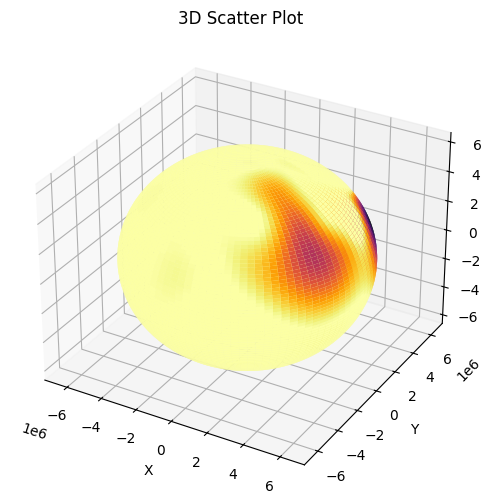

In [65]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

colormap = cm.inferno
normaliser = mpl.colors.Normalize(vmin=np.min(new_data.reshape(new_shape)), vmax=1)
scalar_mappable = cm.ScalarMappable(cmap=colormap, norm=normaliser)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
#ax.scatter(Xs, Ys, Zs, c='b', s=200)
ax.plot_surface(new_Xs.reshape(new_shape),
                new_Ys.reshape(new_shape),
                new_Zs.reshape(new_shape), rstride=1, cstride=1,
                facecolors=colormap(normaliser(new_data.reshape(new_shape))),
                cmap='hot', edgecolor='none')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')
#ax.view_init(0, 0)

plt.show()

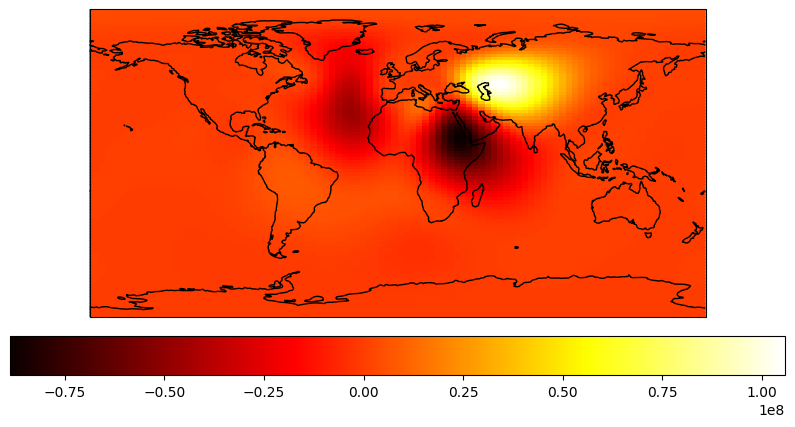

In [63]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
heatmap = ax.pcolormesh(new_lons.reshape(new_shape),
                        new_lats.reshape(new_shape),
                        new_data.reshape(new_shape),
                        cmap='hot',
                        transform=ccrs.PlateCarree())
plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.05)
plt.show()

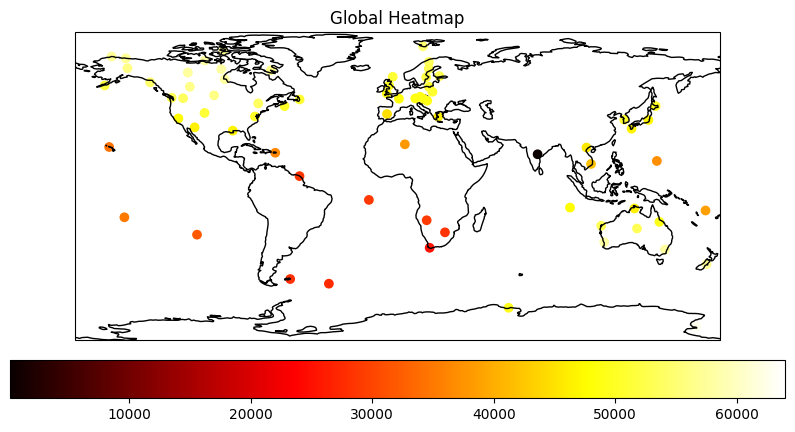

In [64]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
heatmap = ax.scatter(lons, lats, c=data, cmap='hot', transform=ccrs.PlateCarree())
plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.05)
plt.title('Global Heatmap')
plt.show()